In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import roc_auc_score, f1_score, hamming_loss
from transformers import EvalPrediction
from torch.utils.data import Dataset
import nltk
nltk.download('stopwords')
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Read Data

In [46]:
df = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/IMDB-Movie-Data.csv", usecols=["Description", "Genre"])


In [47]:
mask=np.array(Image.open("/content/batman.png"))

In [48]:
df.head()

,Genre,Description
0,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...
1,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te..."
2,"Horror,Thriller",Three girls are kidnapped by a man with a diag...
3,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea..."
4,"Action,Adventure,Fantasy",A secret government agency recruits some of th...


In [49]:
df.shape

(1000, 2)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Genre        1000 non-null   object
 1   Description  1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [51]:
df.isnull().sum()

,0
Genre,0
Description,0


In [52]:
df.duplicated().sum()

0

<ipython-input-53-bca1222e086d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=genre_series, order=genre_series.value_counts().index, palette='gnuplot')


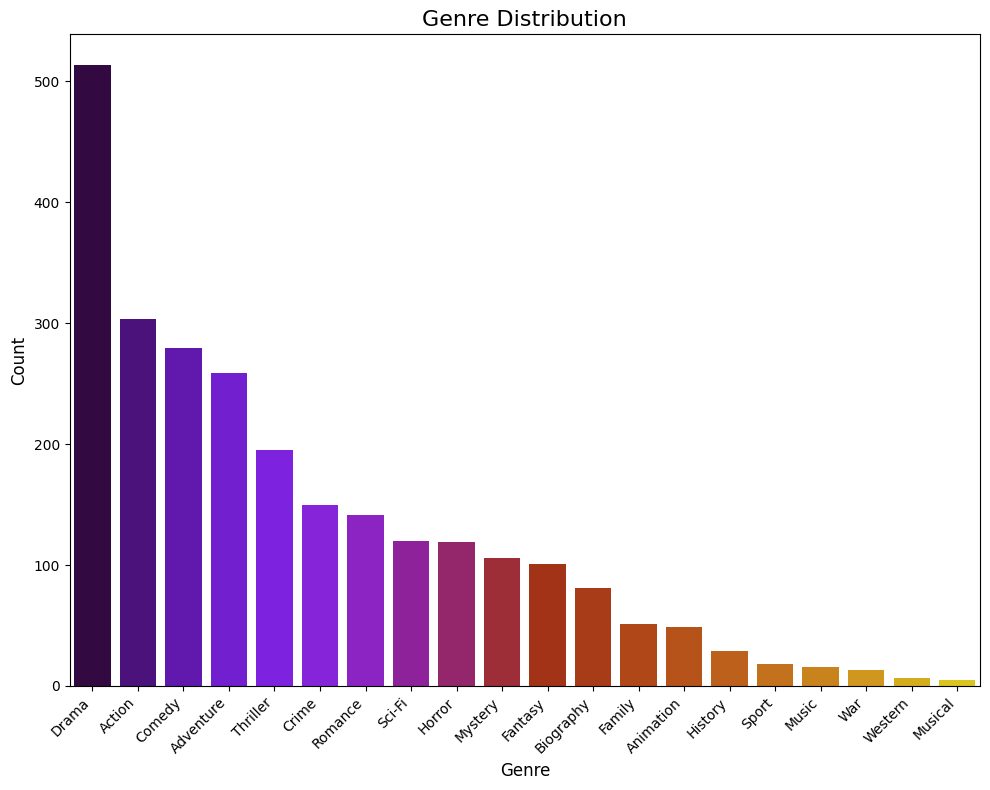

In [53]:
df['Genre'] = df['Genre'].str.split(',')
genre_counts = [g for gen in df['Genre'] for g in gen]
genre_series = pd.Series(genre_counts)

plt.figure(figsize=(10, 8))
sns.countplot(x=genre_series, order=genre_series.value_counts().index, palette='gnuplot')

plt.title("Genre Distribution", fontsize=16)
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Count", fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

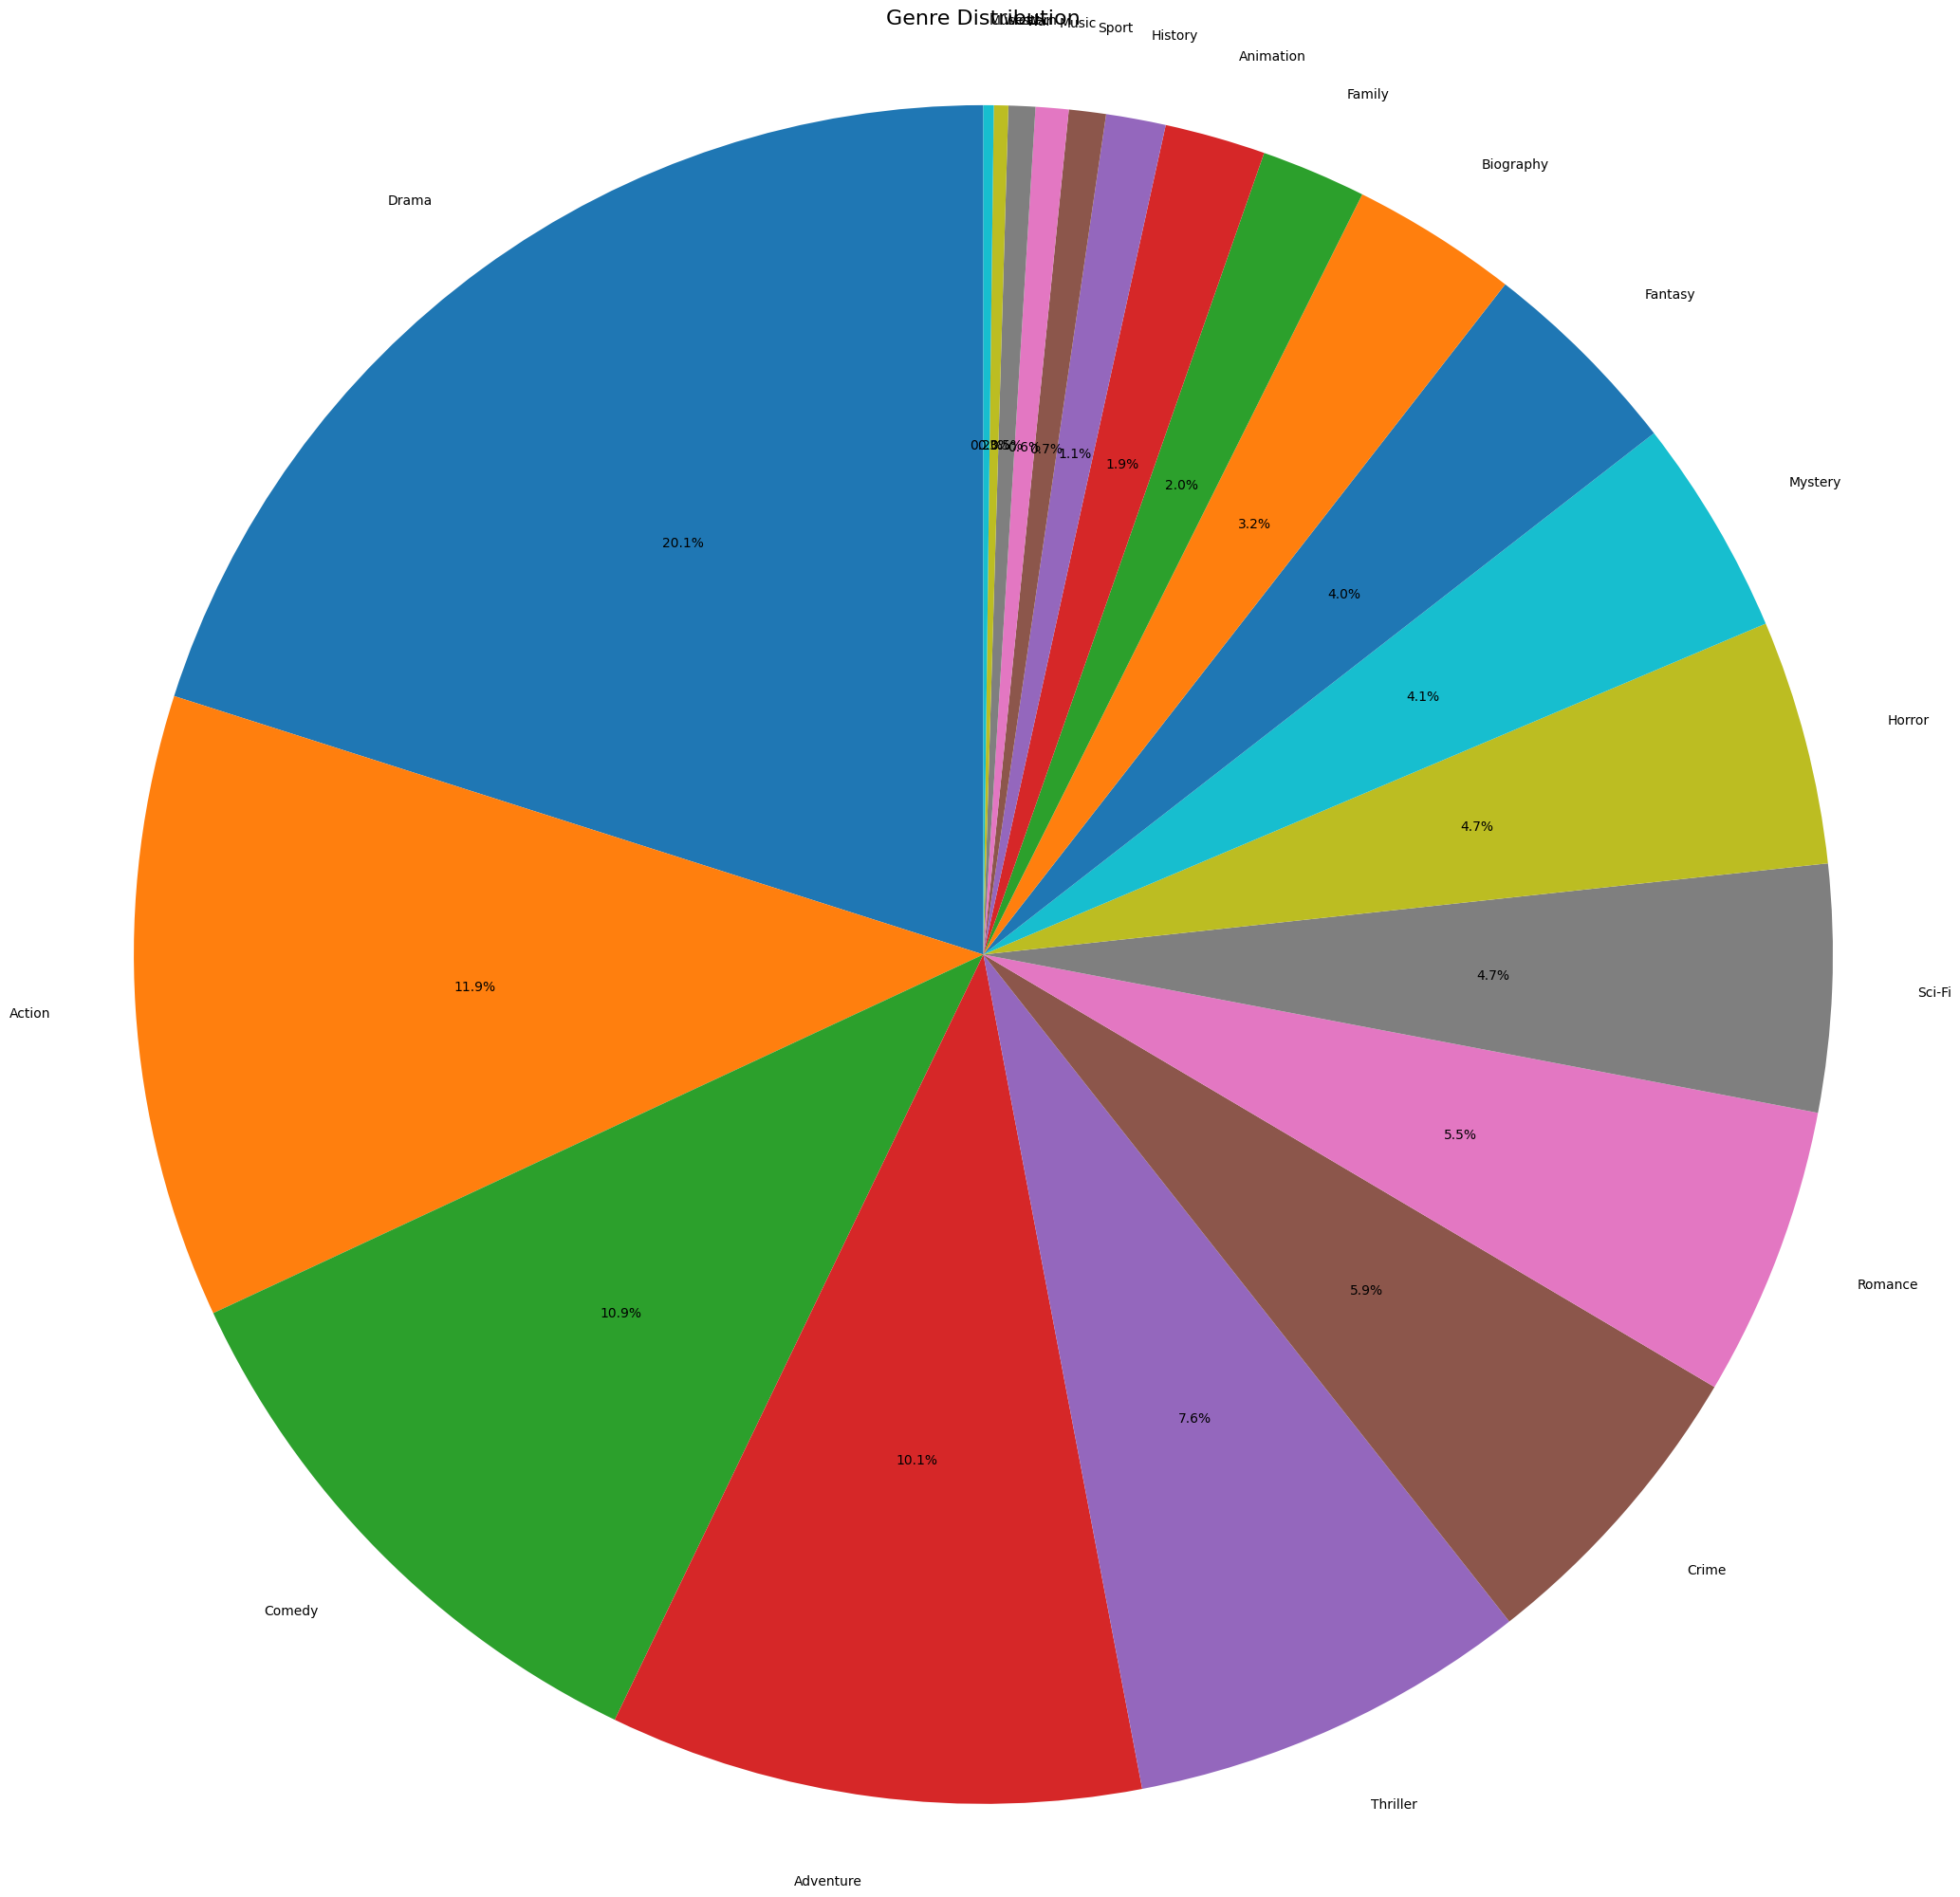

In [54]:
genre_counts = [g for gen in df['Genre'] for g in gen]
genre_series = pd.Series(genre_counts)

genre_count = genre_series.value_counts()

plt.figure(figsize=(20,20))
plt.pie(genre_count, labels=genre_count.index, autopct='%1.1f%%', startangle=90)

plt.title("Genre Distribution", fontsize=16)
plt.tight_layout()
plt.axis("equal")
plt.show()


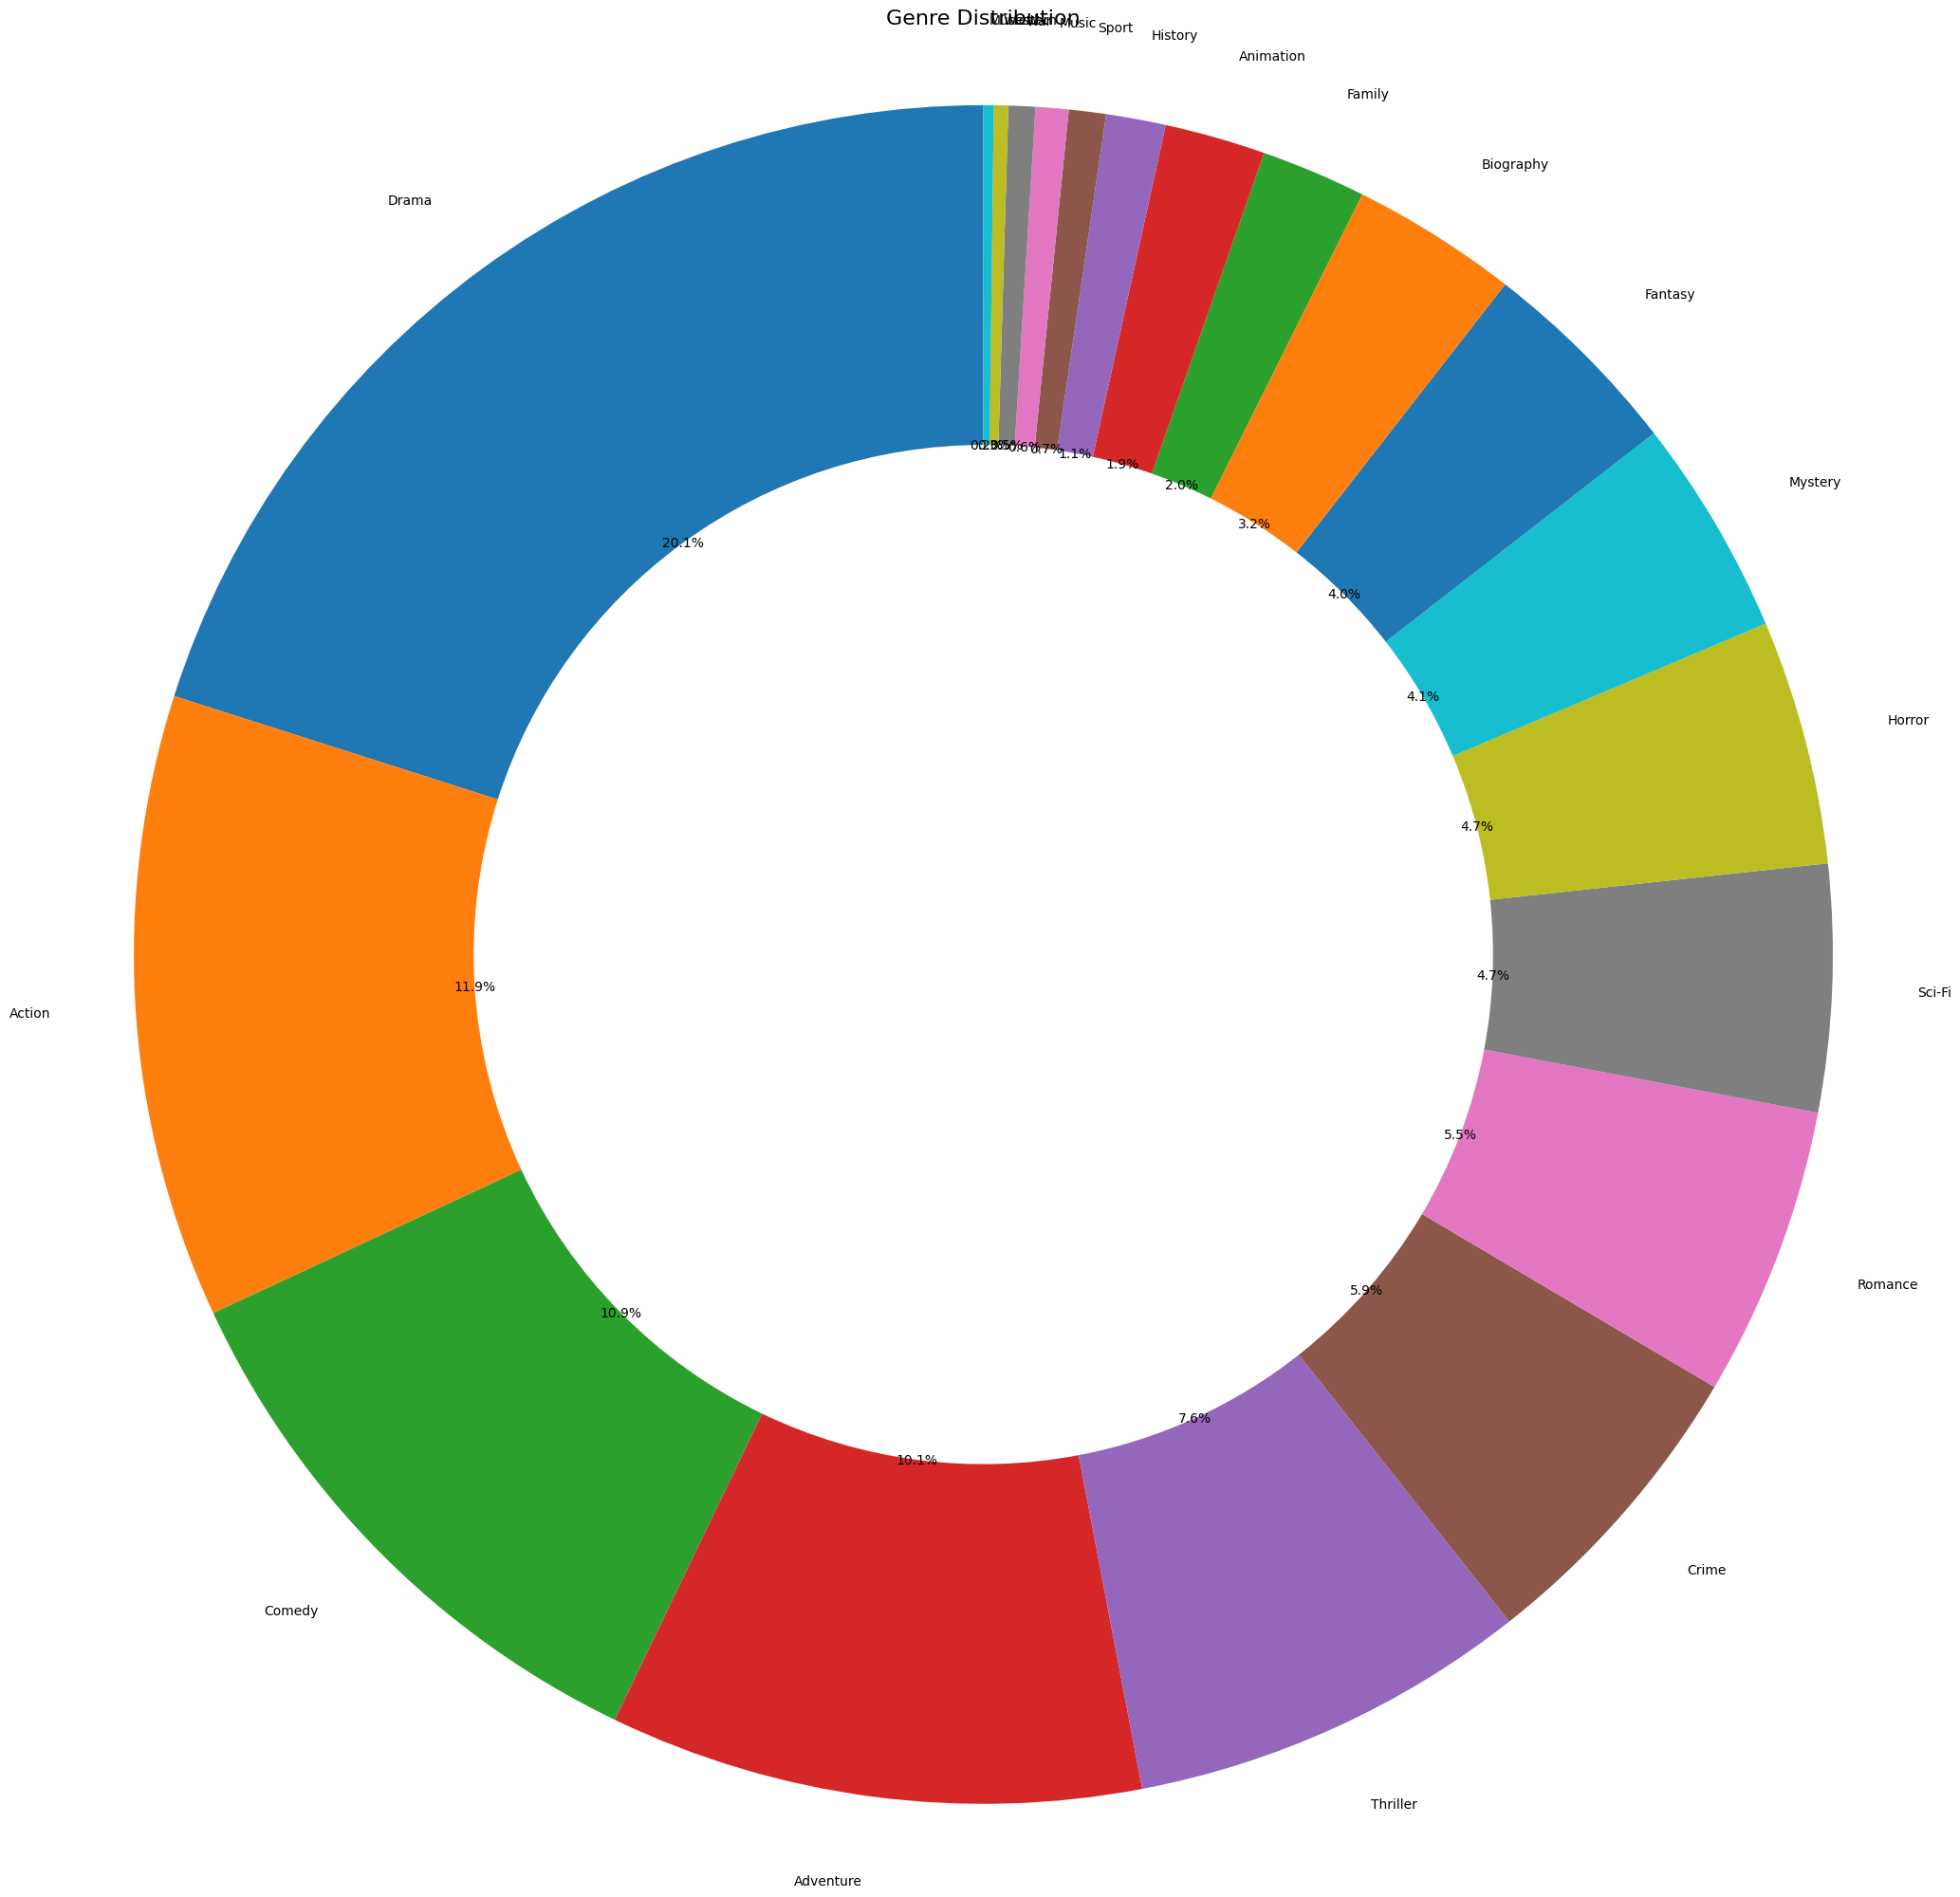

In [55]:
plt.figure(figsize=(20,20))
plt.pie(genre_count, labels=genre_count.index, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.4))

plt.title("Genre Distribution", fontsize=16)
plt.tight_layout()
plt.axis("equal")
plt.show()

In [56]:
df.head()

,Genre,Description
0,"[Action, Adventure, Sci-Fi]",A group of intergalactic criminals are forced ...
1,"[Adventure, Mystery, Sci-Fi]","Following clues to the origin of mankind, a te..."
2,"[Horror, Thriller]",Three girls are kidnapped by a man with a diag...
3,"[Animation, Comedy, Family]","In a city of humanoid animals, a hustling thea..."
4,"[Action, Adventure, Fantasy]",A secret government agency recruits some of th...


# Wordcloud

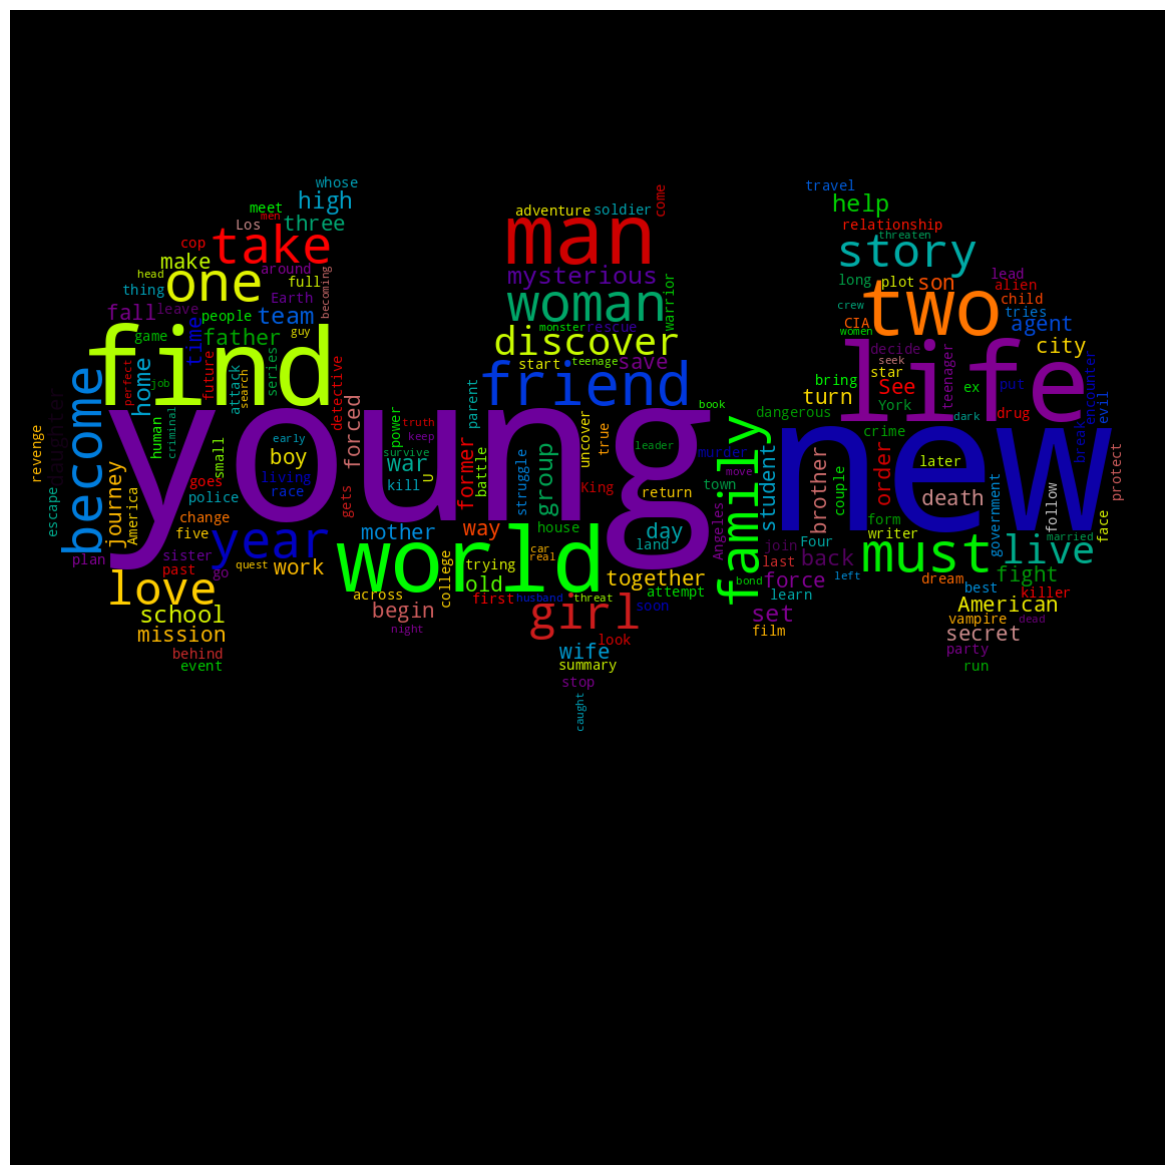

In [57]:
text = " ".join(description for description in df['Description'])

stop_words = set(stopwords.words('english')).union(STOPWORDS)

wordcloud = WordCloud(stopwords=stop_words,width=800,height=800,contour_width=1,contour_color='black',collocations=False,mask=mask,
                     colormap="nipy_spectral",background_color="black").generate(text)

plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 30 Most common Words From All Text

<ipython-input-58-fc0eebb01fcc>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=df_common_words, palette=colors)


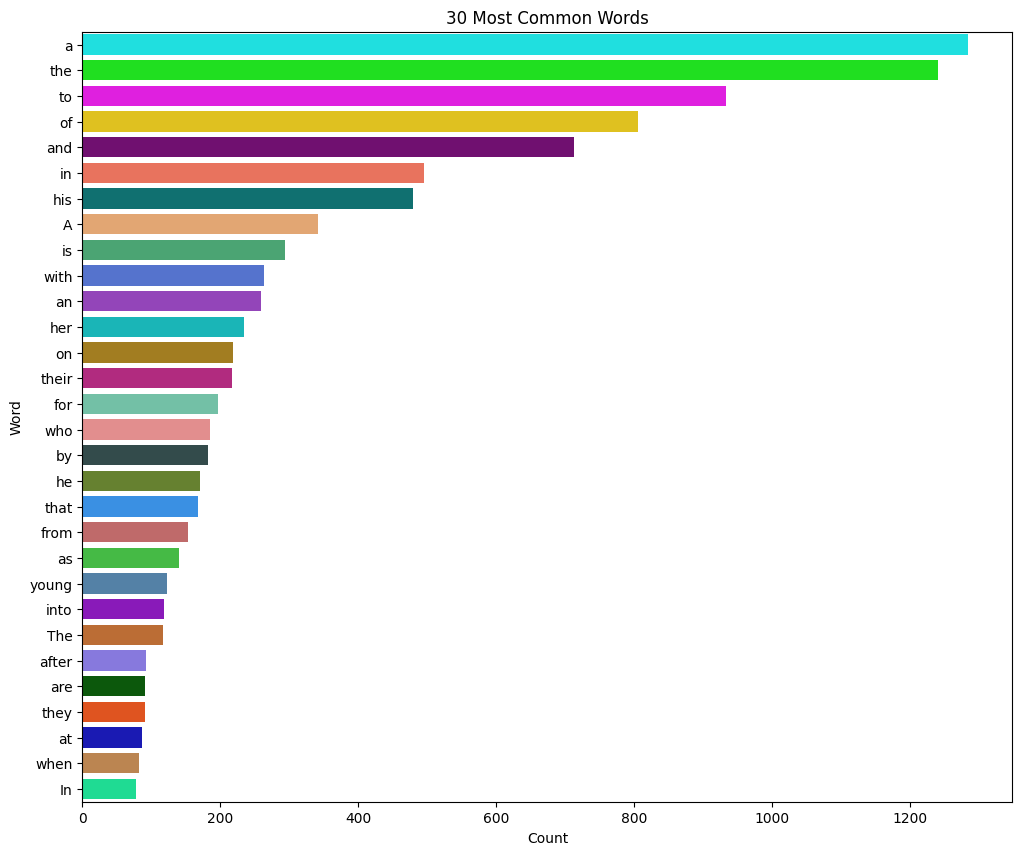

In [58]:
from itertools import chain
from collections import Counter

data_set =df["Description"].str.split()
all_words = list(chain.from_iterable(data_set))
counter = Counter(all_words)
common_words = counter.most_common(30)
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])

colors = ["cyan", "lime", "magenta", "gold", "purple", "tomato", "teal", "sandybrown", "mediumseagreen",
          "royalblue", "darkorchid", "darkturquoise", "darkgoldenrod", "mediumvioletred", "mediumaquamarine",
          "lightcoral", "darkslategray", "olivedrab", "dodgerblue", "indianred", "limegreen", "steelblue",
          "darkviolet", "chocolate", "mediumslateblue", "darkgreen", "orangered", "mediumblue", "peru", "mediumspringgreen"]

plt.figure(figsize=(12, 10))
sns.barplot(x='Count', y='Word', data=df_common_words, palette=colors)
plt.title('30 Most Common Words')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

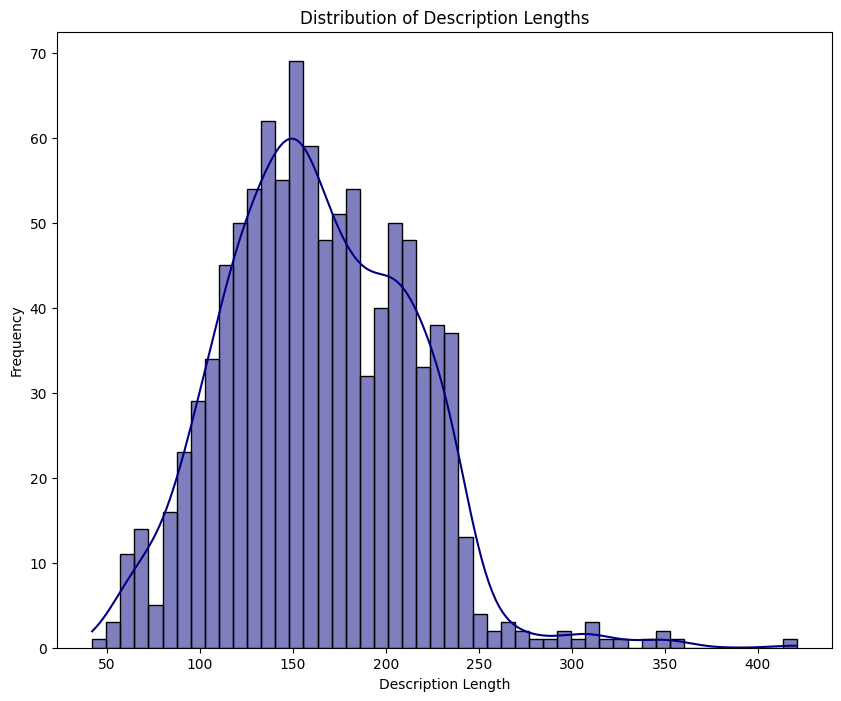

In [59]:
df['Description_Length'] = df['Description'].apply(len)

plt.figure(figsize=(10, 8))
sns.histplot(df['Description_Length'], kde=True, color="navy", bins=50)
plt.title('Distribution of Description Lengths')
plt.xlabel('Description Length')
plt.ylabel('Frequency')
plt.show()

# MultiLabelBinarizer

In [60]:
multilabel = MultiLabelBinarizer()

label_data = multilabel.fit_transform(df['Genre']).astype('float32')
text_data=df["Description"].to_list()

In [61]:
text_data[: 10]

['A group of intergalactic criminals are forced to work together to stop a fanatical warrior from taking control of the universe.',
 'Following clues to the origin of mankind, a team finds a structure on a distant moon, but they soon realize they are not alone.',
 'Three girls are kidnapped by a man with a diagnosed 23 distinct personalities. They must try to escape before the apparent emergence of a frightful new 24th.',
 "In a city of humanoid animals, a hustling theater impresario's attempt to save his theater with a singing competition becomes grander than he anticipates even as its finalists' find that their lives will never be the same.",
 'A secret government agency recruits some of the most dangerous incarcerated super-villains to form a defensive task force. Their first mission: save the world from the apocalypse.',
 'European mercenaries searching for black powder become embroiled in the defense of the Great Wall of China against a horde of monstrous creatures.',
 'A jazz pia

In [62]:
label_data[: 10]

array([[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0.]], dtype=float32)

# Load XLNET Model

In [63]:
from transformers import AutoTokenizer, XLNetForSequenceClassification
xlnet_tokenizer = AutoTokenizer.from_pretrained("xlnet/xlnet-base-cased")
xlnet_model = XLNetForSequenceClassification.from_pretrained("xlnet/xlnet-base-cased",num_labels=len(label_data[0]),
                                                            problem_type="multi_label_classification")


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Split Data

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(text_data,label_data, test_size=0.2, random_state=42)

# Create Custom Dataset

In [65]:
class CreateCustomDataset(Dataset):
    def __init__(self,texts,labels,tokenizer,maxlen=200):
        self.texts=texts
        self.labels=labels
        self.tokenizer=tokenizer
        self.maxlen=maxlen

    def __len__(self):
        return len(self.texts)


    def __getitem__(self,idx):

        text=str(self.texts[idx])
        label=torch.tensor(self.labels[idx])

        encoding=self.tokenizer(text,truncation=True,padding="max_length",max_length=self.maxlen,return_tensors="pt")

        return {"input_ids":encoding["input_ids"].flatten(),
                "attention_mask":encoding["attention_mask"].flatten(),
                "labels":label
               }

In [66]:
train_dataset = CreateCustomDataset(X_train, y_train, xlnet_tokenizer)
val_dataset = CreateCustomDataset(X_test,y_test, xlnet_tokenizer)

# Multi-Label Classification Evaluation Metrics

In [67]:
def calculate_metrics(preds, labels, threshold=0.3):
  sigmoid = torch.nn.Sigmoid()
  probs = sigmoid(torch.Tensor(preds))

  y_pred = np.zeros(probs.shape)
  y_pred[np.where(probs>=threshold)] = 1
  y_true = labels

  f1 = f1_score(y_true, y_pred, average='macro')
  roc_auc = roc_auc_score(y_true, y_pred, average='macro')
  hamming = hamming_loss(y_true, y_pred)

  metrics = {
      "roc_auc": roc_auc,
      "hamming_loss": hamming,
      "f1": f1
  }

  return metrics


def compute_metrics(p: EvalPrediction):
  predictions = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions

  result = calculate_metrics(preds=predictions, labels=p.label_ids)

  return result

# Training Arguments

In [68]:

from transformers import TrainingArguments, Trainer
args = TrainingArguments(
    output_dir='./results',
    run_name='unique_run_name',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    logging_dir='./logs',
    logging_steps=10,
    report_to='wandb',
    disable_tqdm=False,
     evaluation_strategy="steps",
)

trainer = Trainer(model=xlnet_model,
                  args=args,
                  train_dataset=train_dataset,
                  eval_dataset = val_dataset,
                  compute_metrics=compute_metrics)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [69]:
trainer.train()




Step,Training Loss,Validation Loss,Roc Auc,Hamming Loss,F1,Runtime,Samples Per Second,Steps Per Second
10,0.477900,0.341866,0.505551,0.145750,0.074830,3.871500,51.659000,6.457000
20,0.342500,0.336325,0.501678,0.195250,0.097356,3.948700,50.650000,6.331000
30,0.327300,0.328606,0.515012,0.147000,0.089124,4.053800,49.337000,6.167000
40,0.331800,0.331646,0.500000,0.151250,0.054319,4.077200,49.053000,6.132000
50,0.310600,0.319835,0.506626,0.157000,0.079641,4.114300,48.611000,6.076000
60,0.297000,0.303464,0.539803,0.122750,0.111848,3.985200,50.186000,6.273000
70,0.327200,0.305330,0.528283,0.120750,0.109405,3.963700,50.459000,6.307000
80,0.311900,0.308267,0.531535,0.127250,0.131472,3.908200,51.174000,6.397000
90,0.291900,0.307454,0.542378,0.141500,0.136465,3.884500,51.486000,6.436000
100,0.316400,0.304835,0.529832,0.126500,0.121203,3.966600,50.421000,6.303000


TrainOutput(global_step=1000, training_loss=0.17371186238527297, metrics={'train_runtime': 833.9406, 'train_samples_per_second': 9.593, 'train_steps_per_second': 1.199, 'total_flos': 890383756800000.0, 'train_loss': 0.17371186238527297, 'epoch': 10.0})

In [70]:
trainer.evaluate()

{'eval_loss': 0.23858588933944702,
 'eval_roc_auc': 0.6643349868204357,
 'eval_hamming_loss': 0.09675,
 'eval_f1': 0.3930424908955452,
 'eval_runtime': 3.8785,
 'eval_samples_per_second': 51.566,
 'eval_steps_per_second': 6.446,
 'epoch': 10.0}

# Custom Data Prediction

In [72]:
text = "During World War II, the US Army's only all-Black, all-women battalion takes on an impossible mission: sorting through a three-year backlog of 17 million pieces of mail that hadn't been delivered to American soldiers and finish within six months."

encoding = xlnet_tokenizer(text, return_tensors='pt')
encoding.to(trainer.model.device)

outputs = trainer.model(**encoding)
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(outputs.logits[0].cpu())
preds = np.zeros(probs.shape)
preds[np.where(probs>=0.3)] = 1

multilabel.classes_

multilabel.inverse_transform(preds.reshape(1,-1))

[('Action', 'Drama')]